# Experiment 1: Late-fusion

### Text + Audio
- Best TER model on MELD:
- Best SER model on MELD:

### Text + Audio + Image
- Best TER model on MELD:
- Best SER model on MELD:
- Deepface

In [1]:
import os, sys
import pandas as pd
import librosa
import torch
import numpy as np
from collections import defaultdict, Counter
from tqdm import tqdm
tqdm.pandas()
module_path = os.path.abspath(os.path.join('..', '..')) # or the path to your source code
sys.path.insert(0, module_path)
from src.data_loading import filter_emotions, load_meld
#from src.fusion import LateFusion

#meld_train = load_meld(split='train')
#meld_val = load_meld(split='dev')
meld_test = filter_emotions(load_meld(split='test'))



class LateFusion:
    def __init__(self, weights=None, neutral_label="neutral"):
        """
        weights: dict (e.g., {'text': 0.4, 'audio': 0.3, 'video': 0.3})
        neutral_label: label used for neutral emotion (default='neutral')
        """
        self.weights = weights or {'text': 1/3, 'audio': 1/3, 'video': 1/3}
        self.modalities = list(self.weights.keys())
        self.neutral_label = neutral_label

    def _normalize_confidences(self, confidences):
        """Normalize probabilities to sum to 1."""
        total = sum(confidences.values())
        if total == 0:
            return {k: 1/len(confidences) for k in confidences}
        return {k: v / total for k, v in confidences.items()}

    def _aggregate_video(self, video_outputs):
        """
        Aggregate multiple frame-level predictions (labels or probability dicts)
        into a single averaged emotion distribution.
        """
        if not video_outputs:
            return {self.neutral_label: 1.0}

        # if is list of dicts (probabilities)
        if isinstance(video_outputs[0], dict):
            agg = defaultdict(float)
            for frame_pred in video_outputs:
                normed = self._normalize_confidences(frame_pred)
                for emotion, prob in normed.items():
                    agg[emotion] += prob
            return self._normalize_confidences({k: v / len(video_outputs) for k, v in agg.items()})

        # if is list of labels
        else:
            counts = Counter(video_outputs)
            return self._normalize_confidences({k: v / len(video_outputs) for k, v in counts.items()})


    def fuse(self, predictions, top_k=3):
        """
        Fuse predictions from multiple modalities.
        
        predictions: dict
            {
              'text': {'happy': 0.8, 'sad': 0.1, 'neutral': 0.1},
              'audio': 'sad',
              'video': [ {'happy':0.4,'neutral':0.6}, {'happy':0.3,'neutral':0.7} ]
            }

        Returns:
            final_label (str)
            fused_probs (dict)
            top_k_list (list of tuples)
        """
        combined = defaultdict(float)

        for modality, output in predictions.items():
            weight = self.weights.get(modality, 0)

            # modality output type
            if isinstance(output, list):  # frame-wise
                confs = self._aggregate_video(output)
            elif isinstance(output, dict):  # probability distribution
                confs = self._normalize_confidences(output)
            elif isinstance(output, str):  # single label
                confs = {output: 1.0}
            else:
                raise ValueError(f"Unsupported output type for modality {modality}: {type(output)}")

            # weighted accumulation
            for emotion, prob in confs.items():
                combined[emotion] += weight * prob

        # normalize final fused probabilities
        fused_probs = self._normalize_confidences(combined)
        final_label = max(fused_probs, key=fused_probs.get)

        # compute top-k
        sorted_emotions = sorted(fused_probs.items(), key=lambda x: x[1], reverse=True)
        top_k_list = sorted_emotions[:top_k]

        return final_label, fused_probs, top_k_list

    # optional neutral rule
    def rule_based_neutral_override(self, predictions, fused_label):
        """
        Optional rule: if all modalities predict 'neutral', return neutral;
        otherwise keep the fused label.
        """
        non_neutrals = [
            p for p in predictions.values()
            if (isinstance(p, str) and p != self.neutral_label)
            or (isinstance(p, dict) and max(p, key=p.get) != self.neutral_label)
        ]

        if not non_neutrals:
            return self.neutral_label
        return fused_label

fusion = LateFusion(weights={'text': 0.4, 'audio': 0.3, 'video': 0.3})

preds = {
    'text': {'happy': 0.7, 'sad': 0.2, 'neutral': 0.1},
    'audio': 'neutral',
    'video': [
        {'happy': 0.4, 'neutral': 0.6},
        {'happy': 0.3, 'neutral': 0.7}
    ]
}

label, probs, top3 = fusion.fuse(preds)
print("🎯 Final label:", label)
print("📊 Probabilities:", probs)
print("🏆 Top-3:", top3)

/Users/krazmic/Documents/GitHub/Repos/EmoReA/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Subfolders in the dataset: ['JSON files', 'MELD.Raw']
Subfolders in the raw data: ['dia47_utt11.mp4', 'dia35_utt2.mp4', 'dia47_utt9.mp4', 'dia167_utt14.mp4', 'dia232_utt4.mp4', '._dia118_utt11.mp4', 'dia34_utt2.mp4', 'dia268_utt8.mp4', 'dia233_utt4.mp4', '._dia39_utt1.mp4', '._dia230_utt3.mp4', 'dia137_utt0.mp4', '._dia268_utt11.mp4', '._dia231_utt3.mp4', 'dia136_utt0.mp4', '._dia38_utt1.mp4', '._dia34_utt16.mp4', '._dia128_utt2.mp4', 'dia28_utt7.mp4', 'dia195_utt8.mp4', 'dia22_utt15.mp4', '._dia129_utt2.mp4', '._dia100_utt5.mp4', 'dia29_utt7.mp4', 'dia103_utt2.mp4', 'final_videos_testdia48_utt3.mp4', 'dia154_utt12.mp4', '._dia95_utt11.mp4', '._dia205_utt1.mp4', 'dia102_utt2.mp4', 'dia107_utt8.mp4', 'dia253_utt11.mp4', '._dia52_utt5.mp4', 'dia175_utt3.mp4', 'dia93_utt0.mp4', '._dia272_utt0.mp4', '._dia192_utt5.mp4', 'dia174_utt3.mp4', '._dia53_utt5.mp4', 'dia175_utt13.mp4', 'dia92_utt0.mp4', 'dia191_utt2.mp4', 'dia77_utt1.mp4', 'dia259_utt0.mp4', 'dia270_utt7.mp4', 'dia123_utt11.mp4', 

### Process on video file (6s < 10s)

In [ ]:
from src.processor_old import FileProcessor
from src.recognizers_old import TextEmotionRecognizer, SpeechEmotionRecognizer, FaceEmotionRecognizer

#model = "/Users/krazmic/Documents/GitHub/Repos/EmoReA/emorea-backend/notebooks/multimodal/logreg_E.joblib"
#model = "/Users/krazmic/Documents/GitHub/Repos/EmoReA/emorea-backend/notebooks/speech/logreg_C.joblib"
model = "/Users/krazmic/Documents/GitHub/Repos/EmoReA/emorea-backend/notebooks/multimodal/rf_C_FS.joblib"
fp = FileProcessor()
text_recognizer = TextEmotionRecognizer("gemma2")
audio_recognizer = SpeechEmotionRecognizer(model_path=model)
vision_recognizer = FaceEmotionRecognizer()

def multimodal_er(
        filename,
        fp=fp,
        text_recognizer=text_recognizer,
        audio_recognizer=audio_recognizer,
        vision_recognizer=vision_recognizer,
        ):
    file_data = fp.process_file(filename)
    audio_emo = audio_recognizer.analyze(file_data["audio"]['raw'], 16000)
    face_emo = vision_recognizer.analyze_video_frames(file_data["frames"])
    text_emo = text_recognizer.analyze(file_data["text"])

    return (audio_emo, face_emo, text_emo)

    
meld_test['preds'] = meld_test['filename'].progress_apply(multimodal_er)


In [6]:
meld_test.iloc[0]['preds']

('neutral',
 [{'emotions': {'angry': 0.0,
    'disgust': 1.4464581326036336e-20,
    'fear': 100.0,
    'happy': 0.0,
    'sad': 2.8519372627378026e-09,
    'surprise': 7.247253280605571e-33,
    'neutral': 6.12351934245215e-14},
   'dominant_emotion': 'fear'},
  {'emotions': {'angry': 1.6297385589751985e-24,
    'disgust': 99.99915361404419,
    'fear': 0.0008520142728229985,
    'happy': 2.2368856805416004e-33,
    'sad': 9.684274576756216e-20,
    'surprise': 7.769576801533988e-28,
    'neutral': 0.0},
   'dominant_emotion': 'disgust'},
  {'emotions': {'angry': 4.301996736551802e-28,
    'disgust': 3.0873564121902675e-09,
    'fear': 76.4445424079895,
    'happy': 6.049487318578226e-25,
    'sad': 23.55545461177826,
    'surprise': 6.61364265865379e-25,
    'neutral': 3.2184810158495156e-15},
   'dominant_emotion': 'fear'}],
 'neutral')

In [7]:
from src.evaluation import plot_confusion_matrix
from sklearn.metrics import classification_report

fusion = LateFusion(weights={'text': 0.4, 'audio': 0.3, 'video': 0.3})

def get_final_pred(preds):

    audio_emo, face_emo, text_emo = preds
    tav_input = {
        'audio': audio_emo,
        'video': [i['emotions'] for i in face_emo],
        'text': text_emo
    }
    pred_tav = fusion.fuse(tav_input)
    ta_input = {
        'audio': audio_emo,
        #'video': face_emo,
        'text': text_emo
    }
    pred_ta = fusion.fuse(ta_input)

    return (pred_tav, pred_ta)


meld_test['fused'] = meld_test['preds'].progress_apply(get_final_pred)

100%|██████████| 2610/2610 [00:00<00:00, 45595.77it/s]


In [9]:
meld_test['final_tav'] = meld_test['fused'].apply(lambda x: x[0][0])
meld_test['final_ta'] = meld_test['fused'].apply(lambda x: x[1][0])

              precision    recall  f1-score   support

       angry       0.39      0.24      0.30       345
     disgust       0.04      0.35      0.07        68
        fear       0.07      0.22      0.11        50
       happy       0.38      0.33      0.36       402
     neutral       0.62      0.42      0.50      1256
         sad       0.30      0.29      0.30       208
    surprise       0.28      0.25      0.26       281

    accuracy                           0.35      2610
   macro avg       0.30      0.30      0.27      2610
weighted avg       0.46      0.35      0.39      2610



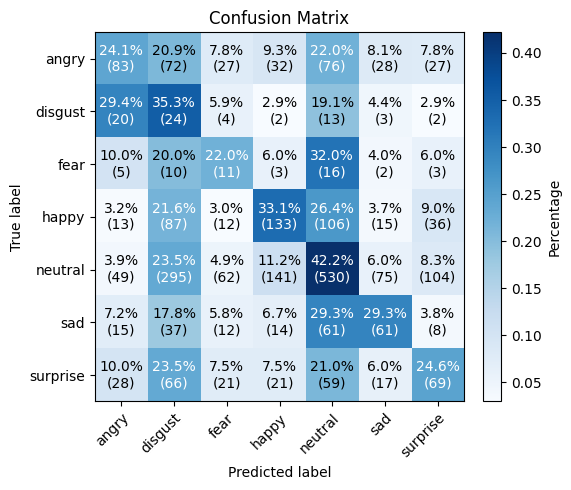

In [10]:
print(classification_report(meld_test['label'], meld_test['final_tav']))
plot_confusion_matrix(meld_test['label'], meld_test['final_tav'])

              precision    recall  f1-score   support

       angry       0.37      0.29      0.33       345
     disgust       0.14      0.18      0.15        68
        fear       0.12      0.28      0.17        50
       happy       0.38      0.39      0.38       402
     neutral       0.62      0.57      0.59      1256
         sad       0.32      0.36      0.34       208
    surprise       0.31      0.37      0.34       281

    accuracy                           0.45      2610
   macro avg       0.32      0.35      0.33      2610
weighted avg       0.47      0.45      0.46      2610



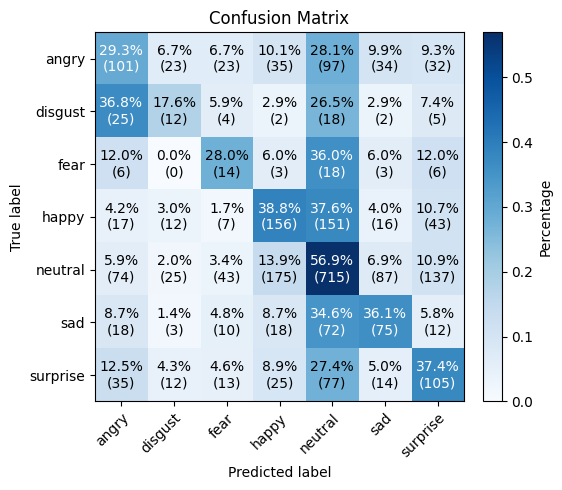

In [11]:
print(classification_report(meld_test['label'], meld_test['final_ta']))
plot_confusion_matrix(meld_test['label'], meld_test['final_ta'])

In [6]:
file_data = fp.process_file(meld_test.iloc[0]['filename'])

MoviePy - Writing audio in /var/folders/ry/9hpdp04n0n58r6p626cfk2gh0000gn/T/tmpn673r9j3.wav


MoviePy - Done.


In [7]:
audio_emo = audio_recognizer.analyze(file_data["audio"]['raw'], 16000)
audio_emo

'neutral'

In [ ]:
face_emo = vision_recognizer.analyze_video_frames(file_data["frames"])
face_emo

Action: emotion: 100%|██████████| 1/1 [00:00<00:00, 36.88it/s]


[{'emotions': {'angry': 0.0,
   'disgust': 1.4464581326036336e-20,
   'fear': 100.0,
   'happy': 0.0,
   'sad': 2.8519372627378026e-09,
   'surprise': 7.247253280605571e-33,
   'neutral': 6.12351934245215e-14},
  'dominant_emotion': 'fear'},
 {'emotions': {'angry': 1.6297385589751985e-24,
   'disgust': 99.99915361404419,
   'fear': 0.0008520142728229985,
   'happy': 2.2368856805416004e-33,
   'sad': 9.684274576756216e-20,
   'surprise': 7.769576801533988e-28,
   'neutral': 0.0},
  'dominant_emotion': 'disgust'},
 {'emotions': {'angry': 4.301996736551802e-28,
   'disgust': 3.0873564121902675e-09,
   'fear': 76.4445424079895,
   'happy': 6.049487318578226e-25,
   'sad': 23.55545461177826,
   'surprise': 6.61364265865379e-25,
   'neutral': 3.2184810158495156e-15},
  'dominant_emotion': 'fear'}]

In [ ]:
text_emo = text_recognizer.analyze(file_data["text"])
text_emo

'neutral'

In [ ]:
preds = {
    'text': text_emo,
    'audio': audio_emo,
    'video': [i['emotions'] for i in face_emo]
}
label, probs, top3 = fusion.fuse(preds)
print("🎯 Final label:", label)
print("📊 Probabilities:", probs)
print("🏆 Top-3:", top3)

🎯 Final label: neutral
📊 Probabilities: {'neutral': 0.41382028391121123, 'happy': 0.30037473039789314, 'angry': 0.0010982991114847306, 'disgust': 5.855429157193812e-07, 'fear': 0.1232582616366992, 'sad': 0.161407970860896, 'surprise': 3.986853890003523e-05}
🏆 Top-3: [('neutral', 0.41382028391121123), ('happy', 0.30037473039789314), ('sad', 0.161407970860896)]


In [10]:
meld_test

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,filename,label
0,1,Why do all youre coffee mugs have numbers on ...,Mark,surprise,positive,0,0,3,19,"00:14:38,127","00:14:40,378",/Users/sofiafernandes/.cache/kagglehub/dataset...,surprise
1,2,Oh. Thats so Monica can keep track. That way ...,Rachel,anger,negative,0,1,3,19,"00:14:40,629","00:14:47,385",/Users/sofiafernandes/.cache/kagglehub/dataset...,angry
2,3,Y'know what?,Rachel,neutral,neutral,0,2,3,19,"00:14:56,353","00:14:57,520",/Users/sofiafernandes/.cache/kagglehub/dataset...,neutral
3,19,"Come on, Lydia, you can do it.",Joey,neutral,neutral,1,0,1,23,"0:10:44,769","0:10:46,146",/Users/sofiafernandes/.cache/kagglehub/dataset...,neutral
4,20,Push!,Joey,joy,positive,1,1,1,23,"0:10:46,146","0:10:46,833",/Users/sofiafernandes/.cache/kagglehub/dataset...,happy
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2605,2760,"Yeah, I mean, come on Ross, no one will even n...",Rachel,neutral,neutral,279,11,6,4,"00:14:35,457","00:14:40,211",/Users/sofiafernandes/.cache/kagglehub/dataset...,neutral
2606,2761,They’re not listening too me?,Ross,surprise,negative,279,12,6,4,"00:14:42,256","00:14:43,840",/Users/sofiafernandes/.cache/kagglehub/dataset...,surprise
2607,2762,Of course they’re listening to you! Everybody ...,Rachel,neutral,neutral,279,13,6,4,"00:14:44,008","00:14:48,511",/Users/sofiafernandes/.cache/kagglehub/dataset...,neutral
2608,2763,Monica you really think I should try this phas...,Ross,neutral,neutral,279,14,6,4,"00:14:48,138","00:14:52,390",/Users/sofiafernandes/.cache/kagglehub/dataset...,neutral
